<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ резюме из HeadHunter
   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('display.width', 200)        # увеличиваем ширину окна вывода
pd.set_option('display.max_columns', None) # показываем все колонки

import os
os.system('cls' if os.name == 'nt' else 'clear')

0

# Исследование структуры данных

1. Читаем данные из файла, название дата фрейма - hh_df, второй дата фрейм - курс валют ExchangeRatesdf

In [2]:

hh_df = pd.read_csv("dst-3.0_16_1_hh_database.csv", sep=";")

ExchangeRatesdf = pd.read_csv("ExchangeRates.csv", sep=",") # курс валют

2. Выводим 5 первых и последних строк таблицы, смотрим другую информацию о дата фрейме

In [3]:
# первые и последние 5 строк
print(hh_df.head(5))
print(hh_df.tail(5))

# количество строк и столбцов
print(hh_df.shape)

# тип данных 
print(hh_df.dtypes)

# размерность, типы данных столбцов, наличие NaN
print(hh_df.info())


                                   Пол, возраст           ЗП                          Ищет работу на должность:                       Город, переезд, командировки   
0    Мужчина ,  39 лет , родился 27 ноября 1979   29000 руб.                            Системный администратор  Советск (Калининградская область) , не готов к...  \
1     Мужчина ,  60 лет , родился 20 марта 1959   40000 руб.                               Технический писатель  Королев , не готов к переезду , готов к редким...   
2  Женщина ,  36 лет , родилась 12 августа 1982   20000 руб.                                           Оператор  Тверь , не готова к переезду , не готова к ком...   
3      Мужчина ,  38 лет , родился 25 июня 1980  100000 руб.  Веб-разработчик (HTML / CSS / JS / PHP / базы ...  Саратов , не готов к переезду , готов к редким...   
4     Женщина ,  26 лет , родилась 3 марта 1993  140000 руб.                  Региональный менеджер по продажам  Москва , не готова к переезду , готова к коман...   

   

3. Выводим основную информацию о числе непустых значений в столбцах и их типах в таблице.

4. Анализируем информацию о числе непустых значений.

In [4]:

# Создаем таблицу с основной информацией о числе непустых значений в столбцах и их типах
info_df = pd.DataFrame({
    'Column': hh_df.columns,
    'Dtype': hh_df.dtypes,
    'Non-Null Count': hh_df.count(),
    'Null Count': hh_df.isnull().sum()
})
print(info_df)


# число пропусков в каждом столбце
print("Пропуски:\n" )
print(hh_df.isna().sum())

# число уникальных значений
print("\nЧисло уникальных значений:\n" )
print(hh_df.nunique())


                                                          Column   Dtype  Non-Null Count  Null Count
Пол, возраст                                        Пол, возраст  object           44744           0
ЗП                                                            ЗП  object           44744           0
Ищет работу на должность:              Ищет работу на должность:  object           44744           0
Город, переезд, командировки        Город, переезд, командировки  object           44744           0
Занятость                                              Занятость  object           44744           0
График                                                    График  object           44744           0
Опыт работы                                          Опыт работы  object           44576         168
Последнее/нынешнее место работы  Последнее/нынешнее место работы  object           44743           1
Последняя/нынешняя должность        Последняя/нынешняя должность  object           44742   

5. Выведим основную статистическую информацию о столбцах


In [5]:
# Статистики по числовым и категориальным признакам
print(hh_df.describe(include='all'))
# print(hh_df.describe(include="object")) только для категориальных признаков 

                                         Пол, возраст          ЗП Ищет работу на должность:                       Город, переезд, командировки         Занятость       График   
count                                           44744       44744                     44744                                              44744             44744        44744  \
unique                                          16003         690                     14929                                              10063                38           47   
top     Мужчина ,  32 года , родился 17 сентября 1986  50000 руб.   Системный администратор  Москва , не готов к переезду , не готов к кома...  полная занятость  полный день   
freq                                               18        4064                      3099                                               1261             30026        22727   

                                              Опыт работы                    Последнее/нынешнее место работы После

# Преобразование данных

1. В этом блоке кода я работаю с признаком "Образование и ВУЗ", который сейчас содержит длинные текстовые строки в формате:
<Уровень образования год выпуска ВУЗ специальность...>

Примеры:

"Высшее образование 2016 Московский авиационный институт..."

"Неоконченное высшее образование 2000 Балтийская государственная академия..."

Мне важно сохранить только уровень образования. Для этого я создаю новый признак "Образование", который свожу к четырём категориям:

"высшее" "неоконченное высшее" "среднее специальное" "среднее"

После преобразования я проверяю корректность новых значений (например, через unique()), а затем удаляю исходный столбец "Образование и ВУЗ", чтобы оставить только очищенный признак.

In [6]:
# Функция для извлечения уровня образования
def get_education_level(text):
    """
    Принимает строку с информацией об образовании.
    Приводит текст к нижнему регистру для корректного поиска.
    Определяет уровень образования по ключевым словам:
        - "неоконченное высшее"
        - "высшее"
        - "среднее специальное"
        - "среднее"
    Возвращает соответствующую категорию или None, если образование не распознано.
    """
    text = text.lower()
    if "неоконченное высшее" in text:
        return "неоконченное высшее"
    elif "высшее" in text:
        return "высшее"
    elif "среднее специальное" in text:
        return "среднее специальное"
    elif "среднее" in text:
        return "среднее"
    else:
        return None

# Создаем новый признак "Образование"
hh_df["Образование"] = hh_df["Образование и ВУЗ"].apply(get_education_level)

# Считаем количество соискателей по каждому уровню
education_counts = hh_df["Образование"].value_counts()

# Удаляем колонку "Образование и ВУЗ"
hh_df = hh_df.drop(columns=["Образование и ВУЗ"])

print("Количество соискателей по уровням образования:")
print(education_counts)

# Проверяем data frame после изменений
# размерность, типы данных столбцов, наличие NaN
print(hh_df.info())

Количество соискателей по уровням образования:
Образование
высшее                 33837
среднее специальное     5748
неоконченное высшее     4603
среднее                  556
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44744 entries, 0 to 44743
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Пол, возраст                     44744 non-null  object
 1   ЗП                               44744 non-null  object
 2   Ищет работу на должность:        44744 non-null  object
 3   Город, переезд, командировки     44744 non-null  object
 4   Занятость                        44744 non-null  object
 5   График                           44744 non-null  object
 6   Опыт работы                      44576 non-null  object
 7   Последнее/нынешнее место работы  44743 non-null  object
 8   Последняя/нынешняя должность     44742 non-null  object
 9   Обновление рез

2. В этом фрагменте кода я обрабатываю столбец "Пол, возраст", который изначально имеет вид:
<Пол , возраст , дата рождения>

Примеры:

"Мужчина , 39 лет , родился 27 ноября 1979"

"Женщина , 21 год , родилась 13 января 2000"

Из этого текста я выделяю два отдельных признака:

"Пол" — с двумя уникальными строковыми значениями: "М" для мужчин и "Ж" для женщин.

"Возраст" — представленный в виде целых чисел.

После преобразования я проверяю корректность полученных данных и удаляю исходный признак "Пол, возраст", так как он становится лишним.

In [7]:
# Функция для извлечения пола из текста
def get_gender(text):
    """
    Принимает строку  
    Приводит текст к нижнему регистру и убирает пробелы
    Проверяет наличие слов "мужчина" или "женщина"
    Возвращает:
        "М" - если найдено "мужчина"
        "Ж" - если найдено "женщина"
        "Не указано" - если пол не распознан
    """
    text = str(text).strip().lower()
    if "мужчина" in text:
        return "М"
    elif "женщина" in text:
        return "Ж"
    else:
        return "Не указано"
    
# Функция для извлечения возраста из текста
def get_age(text):
    """
    Функция извлекает возраст из строки вида "Пол, возраст, ...":
    1. Делит строку по запятой и берёт вторую часть (с возрастом).
    2. Из этой части оставляет только цифры.
    3. Преобразует полученную строку цифр в число и возвращает его.
    """
    
    age_part = text.split(",")[1].strip()  # Получаем часть с возрастом
    age_number = ''.join(filter(str.isdigit, age_part))
    return int(age_number)


# Применяем функции к датафрейму
hh_df["Пол"] = hh_df["Пол, возраст"].apply(get_gender)
hh_df["Возраст"] = hh_df["Пол, возраст"].apply(get_age)

# Удаляем колонку "Пол, возраст" после преобразования
hh_df = hh_df.drop(columns=["Пол, возраст"])

# Считаем количество соискателей по полу
gender_counts = hh_df["Пол"].value_counts()
print("\nКоличество соискателей по полу:")
print(gender_counts)
# Общее количество резюме
total_count = hh_df.shape[0]
# Процентное соотношение
gender_percent = (gender_counts / total_count * 100).round(2)
print("Процентное соотношение по полу:")
print(gender_percent)

# Выводим базовую статистику по возрасту
print("\nСтатистика по возрасту:")
print(hh_df["Возраст"].describe())

# Проверяем data frame после изменений
# размерность, типы данных столбцов, наличие NaN
print(hh_df.info())


Количество соискателей по полу:
Пол
М    36211
Ж     8533
Name: count, dtype: int64
Процентное соотношение по полу:
Пол
М    80.93
Ж    19.07
Name: count, dtype: float64

Статистика по возрасту:
count    44744.000000
mean        32.196741
std          7.929800
min         14.000000
25%         27.000000
50%         31.000000
75%         36.000000
max        100.000000
Name: Возраст, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44744 entries, 0 to 44743
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   ЗП                               44744 non-null  object
 1   Ищет работу на должность:        44744 non-null  object
 2   Город, переезд, командировки     44744 non-null  object
 3   Занятость                        44744 non-null  object
 4   График                           44744 non-null  object
 5   Опыт работы                      44576 non-null  object
 

3. В этом блоке кода я работаю с признаком "Опыт работы", который сейчас представлен в текстовом формате вида:
<Опыт работы: n лет m месяцев, периоды работы в различных компаниях…>

Из этого признака я извлекаю только общий опыт работы и перевожу его в количество месяцев. Новый признак называется "Опыт работы (месяц)".

При преобразовании учитываю несколько особенностей:

если встречаются пропуски или значение "Не указано", они остаются как NaN;

информация о компаниях после указания стажа меня не интересует и игнорируется;

опыт может быть указан только в годах, только в месяцах или в комбинации (например: "3 года 2 месяца", "4 года", "11 месяцев"). Все эти случаи учитываются в расчёте.

В результате я получаю числовой столбец с опытом работы в месяцах. После проверки корректности удаляю исходный признак "Опыт работы".


In [8]:
# Функция для извлечения опыта работы в месяцах
def get_experience(arg):
    """
    Возвращает общий опыт работы в месяцах из строки с годами и месяцами.
    Если значение отсутствует или не указано, возвращает None.
    """
    if pd.isna(arg) or arg == 'Не указано':
        return None
    year_words = ['год', 'года', 'лет']
    month_words = ['месяц', 'месяца', 'месяцев']
    arg_splitted = arg.split(' ')[:7]
    years = 0
    months = 0
    for index, item in enumerate(arg_splitted):
        if item in year_words:
            years = int(arg_splitted[index-1])
        if item in month_words:
            months = int(arg_splitted[index-1])
    return int(years*12 + months)

# Применяем функцию к hh_df
hh_df['Опыт работы (месяц)'] = hh_df['Опыт работы'].apply(get_experience)

# Если нужно, можно удалить исходный столбец
hh_df = hh_df.drop('Опыт работы', axis=1)

# Медианный опыт работы
print("Медианный опыт работы (в месяцах):", round(hh_df['Опыт работы (месяц)'].median()))
print(hh_df['Опыт работы (месяц)'].describe())

# Проверяем data frame после изменений
# размерность, типы данных столбцов, наличие NaN
print(hh_df.info())


Медианный опыт работы (в месяцах): 100
count    44574.000000
mean       114.418944
std         79.047861
min          1.000000
25%         57.000000
50%        100.000000
75%        154.000000
max       1188.000000
Name: Опыт работы (месяц), dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44744 entries, 0 to 44743
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ЗП                               44744 non-null  object 
 1   Ищет работу на должность:        44744 non-null  object 
 2   Город, переезд, командировки     44744 non-null  object 
 3   Занятость                        44744 non-null  object 
 4   График                           44744 non-null  object 
 5   Последнее/нынешнее место работы  44743 non-null  object 
 6   Последняя/нынешняя должность     44742 non-null  object 
 7   Обновление резюме                44744 non-null  object 
 8   Авто     

4. В этом блоке кода я разбираю признак "Город, переезд, командировки", где в одной строке содержатся данные о городе проживания, ближайшем метро (не всегда), готовности к переезду и готовности к командировкам.

Из этого признака я формирую три новых:

"Город" — свожу все значения к четырём категориям: "Москва", "Санкт-Петербург", "город-миллионник" (из заранее заданного списка) и "другие". Информация о метро игнорируется.

"Готовность к переезду" — привожу к булевому формату (True/False), учитывая разные формулировки вроде «готова к переезду», «хочу переехать» и т.п.

"Готовность к командировкам" — тоже булево значение, где True означает любую готовность (даже «редкие командировки»), а если информация отсутствует — считаю, что кандидат не готов (False).

После проверки удаляю исходный признак "Город, переезд, командировки".

In [9]:
# Список городов-миллионников (без Москвы и СПб)
million_cities = [
    "Новосибирск", "Екатеринбург", "Нижний Новгород",
    "Казань", "Челябинск", "Омск", "Самара", "Ростов-на-Дону",
    "Уфа", "Красноярск", "Воронеж", "Пермь", "Волгоград"
]

def parse_location(text):
    """
    Вход: строка с информацией о городе, возможном переезде и командировках
    Выход: pd.Series с тремя элементами:
    - город (Москва, Санкт-Петербург, город-миллионник, другие)
    - готовность к переезду (False, True)
    - готовность к командировкам (False, True)
    """
    if pd.isna(text):
        return pd.Series([np.nan, False, False])
    
    parts = [p.strip() for p in text.split(',')]
    
    # 1. Город
    city = parts[0]
    if city == "Москва" or city == "Санкт-Петербург":
        city_cat = city
    elif city in million_cities:
        city_cat = "город-миллионник"
    else:
        city_cat = "другие"
    
    text_lower = text.lower()
    
    # 2. Готовность к переезду
    if any(k in text_lower for k in ["не готов к переезду", "не готова к переезду"]):
        move = False
    elif any(k in text_lower for k in ["готов к переезду", "готова к переезду", "хочу переехать"]):
        move = True
    else:
        move = False  # по умолчанию False
    
    # 3. Готовность к командировкам
    travel_keywords = ["готов к командировкам", "готова к командировкам", 
                       "готова к редким командировкам", "готов к редким командировкам"]
    not_travel_keywords = ["не готов к командировкам", "не готова к командировкам"]
    
    if any(k in text_lower for k in not_travel_keywords):
        travel = False
    elif any(k in text_lower for k in travel_keywords):
        travel = True
    else:
        travel = False  # если информации нет → False по умолчанию
    
    return pd.Series([city_cat, move, travel])

# Применяем функцию к hh_df
hh_df[['Город', 'Готовность к переезду', 'Готовность к командировкам']] = \
    hh_df['Город, переезд, командировки'].apply(parse_location)

# Удаляем исходный столбец
hh_df = hh_df.drop(columns=['Город, переезд, командировки'])

# Фильтруем датафрейм по этим городам
filtered = hh_df[hh_df['Город'].isin(['другие', 'Москва', 'город-миллионник', 'Санкт-Петербург'])]
# Считаем количество по каждому городу
counts = filtered['Город'].value_counts()
# Добавляем процент
percent = counts / len(hh_df) * 100
# Объединяем в один DataFrame для наглядности
result = pd.DataFrame({'Количество': counts, 'Процент': percent.round(2)})
print(result)

# Проверяем уникальные значения признаков
print(hh_df[['Город', 'Готовность к переезду', 'Готовность к командировкам']].head(10))
print(hh_df['Город'].unique())

# Считаем все комбинации
counts = pd.crosstab(hh_df['Готовность к переезду'], hh_df['Готовность к командировкам'])
print(counts)
# Проценты
percentages = pd.crosstab(hh_df['Готовность к переезду'], hh_df['Готовность к командировкам'], normalize=True) * 100
percentages = percentages.round(2)
print(percentages)

print(hh_df.info())

                  Количество  Процент
Город                                
Москва                 16621    37.15
другие                 15854    35.43
город-миллионник        7332    16.39
Санкт-Петербург         4937    11.03
    Город  Готовность к переезду  Готовность к командировкам
0  другие                  False                       False
1  другие                  False                        True
2  другие                  False                       False
3  другие                  False                        True
4  Москва                  False                        True
5  другие                  False                       False
6  Москва                  False                        True
7  Москва                   True                        True
8  Москва                   True                        True
9  Москва                  False                       False
['другие' 'Москва' 'город-миллионник' 'Санкт-Петербург']
Готовность к командировкам  False  True 
Гот

5. В этом фрагменте кода я преобразую признаки "Занятость" и "График". Сейчас они содержат различные комбинации категорий (например: «полная занятость, частичная занятость» или «вахтовый метод, гибкий график, удалённая работа»), из-за чего получается слишком много уникальных значений.

Чтобы упростить анализ, я применяю метод One Hot Encoding: для каждой категории создаю отдельный бинарный признак. Если категория указана кандидатом — в соответствующей ячейке ставится True, иначе False.

После этого я удаляю исходные столбцы "Занятость" и "График", оставляя только новые признаки-индикаторы.

In [10]:
# Списки категорий
employment_categories = [
    "полная занятость", "частичная занятость", "проектная работа", "волонтерство", "стажировка"
]

# One Hot Encoding для занятости
for cat in employment_categories:
    hh_df[cat] = hh_df['Занятость'].str.contains(cat).fillna(False)
    
schedule_categories = [
    "полный день", "сменный график", "гибкий график", "удаленная работа", "вахтовый метод"
]

# One Hot Encoding для графика
for cat in schedule_categories:
    hh_df[cat] = hh_df['График'].str.contains(cat).fillna(False)

# Убираем исходные текстовые колонки
hh_df = hh_df.drop(columns=['Занятость', 'График'])

# Проверим результат
print(hh_df.info())
hh_df.head()

# Проверим результат
print(hh_df.info())
hh_df.head()

# count_1 = hh_df[(hh_df['проектная работа']) & (hh_df['волонтерство'])].shape[0]
# print("проектная работа и волонтерство - ",count_1)

# count_2 = hh_df[(hh_df['вахтовый метод']) & (hh_df['гибкий график'])].shape[0]
# print("вахтовый метод и гибкий график - ",count_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44744 entries, 0 to 44743
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ЗП                               44744 non-null  object 
 1   Ищет работу на должность:        44744 non-null  object 
 2   Последнее/нынешнее место работы  44743 non-null  object 
 3   Последняя/нынешняя должность     44742 non-null  object 
 4   Обновление резюме                44744 non-null  object 
 5   Авто                             44744 non-null  object 
 6   Образование                      44744 non-null  object 
 7   Пол                              44744 non-null  object 
 8   Возраст                          44744 non-null  int64  
 9   Опыт работы (месяц)              44574 non-null  float64
 10  Город                            44744 non-null  object 
 11  Готовность к переезду            44744 non-null  bool   
 12  Готовность к коман

,ЗП,Ищет работу на должность:,Последнее/нынешнее место работы,Последняя/нынешняя должность,Обновление резюме,Авто,Образование,Пол,Возраст,Опыт работы (месяц),Город,Готовность к переезду,Готовность к командировкам,полная занятость,частичная занятость,проектная работа,волонтерство,стажировка,полный день,сменный график,гибкий график,удаленная работа,вахтовый метод
0,29000 руб.,Системный администратор,"МАОУ ""СОШ № 1 г.Немана""",Системный администратор,16.04.2019 15:59,Имеется собственный автомобиль,неоконченное высшее,М,39,202.0,другие,False,False,True,True,True,False,False,True,True,True,True,True
1,40000 руб.,Технический писатель,Временный трудовой коллектив,"Менеджер проекта, Аналитик, Технический писатель",12.04.2019 08:42,Не указано,высшее,М,60,233.0,другие,False,True,True,True,True,False,False,True,True,True,True,False
2,20000 руб.,Оператор,ПАО Сбербанк,Кассир-операционист,16.04.2019 08:35,Не указано,среднее специальное,Ж,36,123.0,другие,False,False,True,False,False,False,False,True,False,False,False,False
3,100000 руб.,Веб-разработчик (HTML / CSS / JS / PHP / базы ...,OpenSoft,Инженер-программист,08.04.2019 14:23,Не указано,высшее,М,38,225.0,другие,False,True,True,True,True,False,False,False,False,True,True,False
4,140000 руб.,Региональный менеджер по продажам,Мармелад,Менеджер по продажам,22.04.2019 10:32,Не указано,высшее,Ж,26,67.0,Москва,False,True,True,False,False,False,False,True,False,False,False,False


6. В этом блоке кода я преобразую признак "ЗП", где зарплата указана вместе с валютой (например: «30000 руб.», «50000 грн.», «550 USD»). Чтобы данные были сопоставимы, я перевожу все значения в рубли.

Для этого использую выгруженные курсы валют за период, соответствующий датам обновления резюме. В таблице с курсами беру столбцы "currency", "date", "proportion" и "close", учитывая, что курс может быть указан не за 1, а за несколько единиц валюты (например, за 100 тенге). Правильный курс получаю как close / proportion.

Затем сопоставляю зарплату с курсом по дате обновления резюме (беру только дату, время не нужно). В результате получаю новый признак "ЗП (руб)" — желаемую зарплату в рублях.

После проверки удаляю исходный признак "ЗП" и все промежуточные столбцы, использованные для расчёта

Для преобразования признака "ЗП" я действую пошагово:

Перевожу даты в обоих таблицах ("Обновление резюме" и "date" в курсах валют) в формат datetime и оставляю только дату.

Из столбца "ЗП" выделяю сумму и валюту, при этом валюту привожу к стандарту ISO с помощью таблицы соответствий.

Объединяю таблицу с резюме и таблицу с курсами валют по дате и валюте так, чтобы в данных по резюме сохранились все зарплаты, указанные в рублях. Для рубля курс заполняю значением 1.

Рассчитываю новую колонку "ЗП (руб)": умножаю сумму зарплаты на курс (close) и делю на пропорцию. Учитываю возможные пропуски, которые могли появиться после объединения.

В результате получаю единый показатель заработной платы в рублях, после чего удаляю исходный столбец "ЗП" и все вспомогательные признаки.


In [11]:
def get_salary_num(arg):
    salary = float(arg.split(' ')[0])
    return salary

def get_salary_currency(arg):
    currency_dict = {
        'USD': 'USD', 'KZT': 'KZT',
        'грн': 'UAH', 'белруб': 'BYN',
        'EUR': 'EUR', 'KGS': 'KGS',
        'сум': 'UZS', 'AZN': 'AZN'
    }
    curr = arg.split(' ')[1].replace('.', '')
    if curr == 'руб':
        return 'RUB'
    else:
        return currency_dict[curr]

# приводим даты в ExchangeRatesdf
ExchangeRatesdf['date'] = pd.to_datetime(ExchangeRatesdf['date'], dayfirst=True).dt.date

# приводим даты в hh_df
hh_df['Обновление резюме'] = pd.to_datetime(hh_df['Обновление резюме'], dayfirst=True).dt.date

# временные столбцы
hh_df['ЗП (tmp)'] = hh_df['ЗП'].apply(get_salary_num)
hh_df['Курс (tmp)'] = hh_df['ЗП'].apply(get_salary_currency)

# объединяем с курсами
merged = hh_df.merge(
    ExchangeRatesdf, 
    left_on=['Курс (tmp)', 'Обновление резюме'],
    right_on=['currency', 'date'], 
    how='left'
)

# обрабатываем NaN
merged['close'] = merged['close'].fillna(1)
merged['proportion'] = merged['proportion'].fillna(1)

# считаем зарплату в рублях
hh_df['ЗП (руб)'] = merged['close'] * merged['ЗП (tmp)'] / merged['proportion']

# удаляем временные колонки
hh_df = hh_df.drop(['ЗП', 'ЗП (tmp)', 'Курс (tmp)'], axis=1)

# вывод медианной зарплаты 
median_salary = hh_df['ЗП (руб)'].median()
print("Медианная зар плата - ", median_salary)
# (в тысячах рублей)
print("Медианная зарплаты (в тысячах рублей) -",round(hh_df['ЗП (руб)'].median() / 1000))




C:\Users\Chuni\AppData\Local\Temp\ipykernel_23316\4113204150.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ExchangeRatesdf['date'] = pd.to_datetime(ExchangeRatesdf['date'], dayfirst=True).dt.date


Медианная зар плата -  59019.0
Медианная зарплаты (в тысячах рублей) - 59


# Исследование зависимостей в данных

1. В этом шаге я исследую распределение признака "Возраст". Для наглядности строю гистограмму и коробчатую диаграмму.

После визуализации описываю распределение:

нахожу моду — наиболее часто встречающийся возраст;

определяю минимальное и максимальное значения;

выделяю основной интервал, в котором находится большинство соискателей;

анализирую наличие аномалий (крайне низкие или крайне высокие значения возраста, которые выбиваются из общей картины).

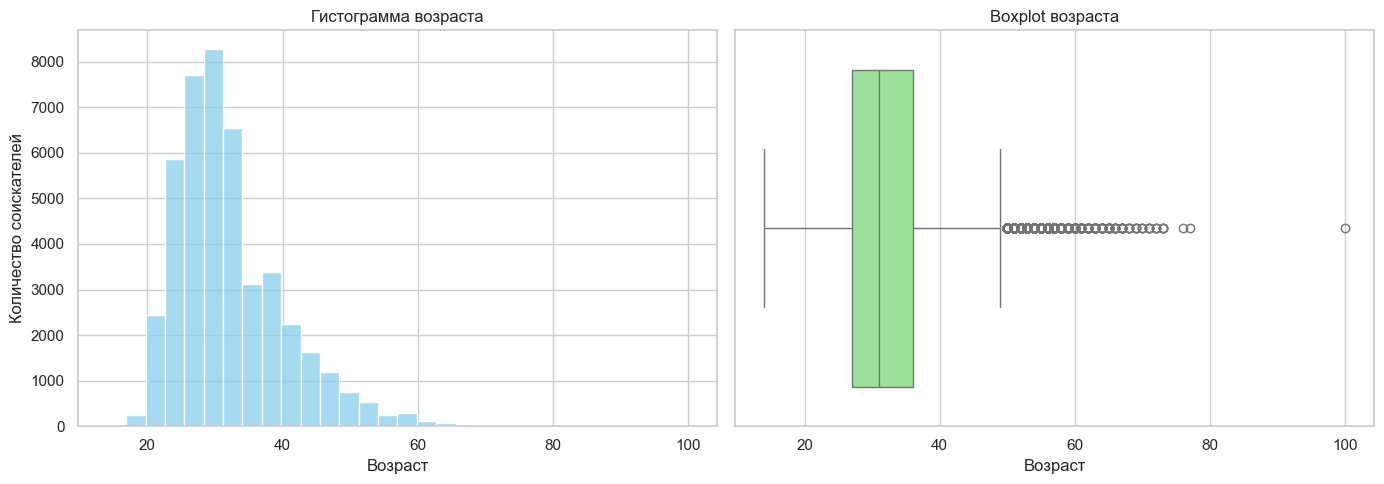

Мода возраста: 30
Минимальное значение: 14
Максимальное значение: 100
Медиана: 31.0
Интерквартильный размах: 9.0
Границы выбросов: [13.5, 49.5]
Количество аномальных значений: 1774
Примерные аномальные значения: [ 60  59  53  54  62  72  61  50  58  57  52  56  51  71  63  55  64  68
  73  66  65  77  67  69  76  70 100]


In [12]:
# Настройка стиля
sns.set(style="whitegrid")

# Создаем фигуру с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма
sns.histplot(hh_df['Возраст'], bins=30, kde=False, ax=axes[0], color='skyblue')
axes[0].set_title('Гистограмма возраста')
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('Количество соискателей')

# Коробчатая диаграмма
sns.boxplot(x=hh_df['Возраст'], ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot возраста')

plt.tight_layout()
plt.show()

# Дополнительно: вычисляем числовые характеристики
mode_age = hh_df['Возраст'].mode()[0]
min_age = hh_df['Возраст'].min()
max_age = hh_df['Возраст'].max()
median_age = hh_df['Возраст'].median()
q1 = hh_df['Возраст'].quantile(0.25)
q3 = hh_df['Возраст'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = hh_df[(hh_df['Возраст'] < lower_bound) | (hh_df['Возраст'] > upper_bound)]

print(f"Мода возраста: {mode_age}")
print(f"Минимальное значение: {min_age}")
print(f"Максимальное значение: {max_age}")
print(f"Медиана: {median_age}")
print(f"Интерквартильный размах: {iqr}")
print(f"Границы выбросов: [{lower_bound}, {upper_bound}]")
print(f"Количество аномальных значений: {len(outliers)}")
print(f"Примерные аномальные значения: {outliers['Возраст'].unique()}")

**Выводы -** 
1. Наиболее частый возраст соискателей 30 лет (мода), половина соискателей возрастом менее 31 года, половина старше (медиана)
2. Минимальный возраст 14 (редкий случай или ошибка ввода), максимальный 100 (очивидный выброс, маловероятно что кандидат такого возраста)
3. Основной возрастной интервал (межквартальный разброс) 31 - + 4.5  (примерно 27-36 лет)
4. Большинсто соискателей в диапазоне 25-40 лет , типичная активность на рынке 
5. К аномалиям можем отнести возраст 57-100 лет 

Возрастная структура нормальная, с пиком около 30 лет. Выбросы есть, но их доля невелика. Для анализа зарплат, опыта работы или других признаков стоит учитывать основной возрастной диапазон 25–40 лет и исключить аномалии (14 лет и пенсионный возраст например 60-100 лет)

2. В этом шаге я анализирую распределение признака "Опыт работы (месяц)". Для этого строю гистограмму и коробчатую диаграмму.

Далее описываю распределение:

определяю моду — наиболее часто встречающийся опыт работы;

нахожу минимальное и максимальное значения;

выделяю основной диапазон, в котором находится опыт работы большинства соискателей;

рассматриваю возможные аномалии — слишком маленькие или слишком большие значения, не соответствующие реальной трудовой практике.

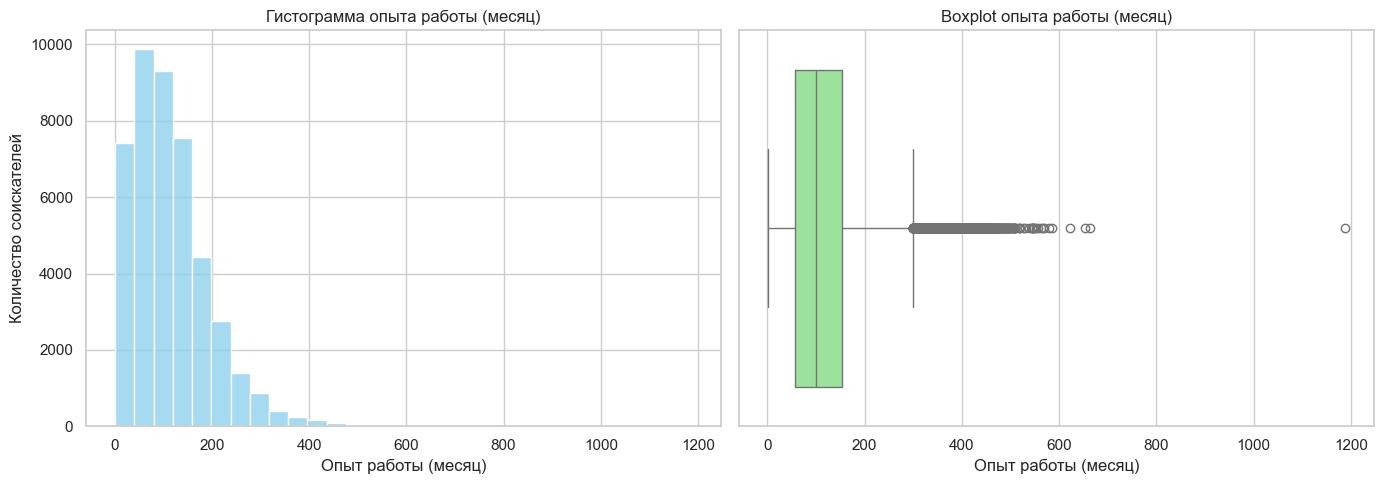

Мода опыта работы: 81.0
Минимальное значение: 1.0
Максимальное значение: 1188.0
Медиана: 100.0
Интерквартильный размах: 97.0
Границы выбросов: [-88.5, 299.5]
Количество аномальных значений: 1276
Примерные аномальные значения, 300месяцев (25 лет) опаты и больше : [ 510.  325.  303.  360.  312.  324.  468.  507.  469.  401.  330.  438.
  417.  389.  370.  334.  321.  442.  377.  317.  302.  357.  358.  300.
  455.  402.  452.  307.  304.  322.  301.  345.  306.  497.  340.  369.
  399.  384.  439.  382.  421.  314.  359.  348.  309.  425.  313.  495.
  310.  400.  347.  423.  308.  429.  315.  411.  338.  363.  383.  373.
  482.  388.  352.  380.  366.  333.  329.  362.  343.  461.  350.  311.
  446.  332.  367.  454.  447.  341.  407.  392.  663.  403.  517.  374.
  316.  424.  337.  305.  414.  467.  356.  390.  355.  394.  418.  420.
  443.  504.  437.  496.  335.  346.  546.  457.  412.  344.  393.  342.
  323.  410.  365.  406.  396.  408.  351.  458.  331.  415.  319.  385.
  395. 

In [13]:
# Настройка стиля
sns.set(style="whitegrid")

# Создаем фигуру с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма
sns.histplot(hh_df['Опыт работы (месяц)'].dropna(), bins=30, kde=False, ax=axes[0], color='skyblue')
axes[0].set_title('Гистограмма опыта работы (месяц)')
axes[0].set_xlabel('Опыт работы (месяц)')
axes[0].set_ylabel('Количество соискателей')

# Коробчатая диаграмма
sns.boxplot(x=hh_df['Опыт работы (месяц)'].dropna(), ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot опыта работы (месяц)')

plt.tight_layout()
plt.show()

# Числовые характеристики
mode_exp = hh_df['Опыт работы (месяц)'].mode()[0]
min_exp = hh_df['Опыт работы (месяц)'].min()
max_exp = hh_df['Опыт работы (месяц)'].max()
median_exp = hh_df['Опыт работы (месяц)'].median()
q1 = hh_df['Опыт работы (месяц)'].quantile(0.25)
q3 = hh_df['Опыт работы (месяц)'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = hh_df[(hh_df['Опыт работы (месяц)'] < lower_bound) | (hh_df['Опыт работы (месяц)'] > upper_bound)]

print(f"Мода опыта работы: {mode_exp}")
print(f"Минимальное значение: {min_exp}")
print(f"Максимальное значение: {max_exp}")
print(f"Медиана: {median_exp}")
print(f"Интерквартильный размах: {iqr}")
print(f"Границы выбросов: [{lower_bound}, {upper_bound}]")
print(f"Количество аномальных значений: {len(outliers)}")
print(f"Примерные аномальные значения, 300месяцев (25 лет) опаты и больше : {outliers['Опыт работы (месяц)'].unique()}")

**Выводы-**

Мода опыта работы: 81 месяц (~7 лет), медиана: 100 месяцев (~8 лет).

Большинство соискателей: имеют опыт от ~3 до 16 лет.

Выбросы: 1276 записей (~3%), опыт больше 25 лет (300+ месяцев) — скорее ошибки ввода или редкие случаи.

Вывод: распределение сдвинуто вправо, для анализа можно учитывать опыт до 25 лет

3. В этом шаге я анализирую распределение признака "ЗП (руб)". Для визуализации строю гистограмму и коробчатую диаграмму рядом.

Далее описываю распределение:

определяю минимальное и максимальное значения;

выделяю примерный интервал, в котором находится зарплата большинства соискателей;

отмечаю аномалии — крайне высокие или низкие значения, которые сильно выбиваются из общей картины (особое внимание уделяю гигантским суммам, не соответствующим реальному рынку).

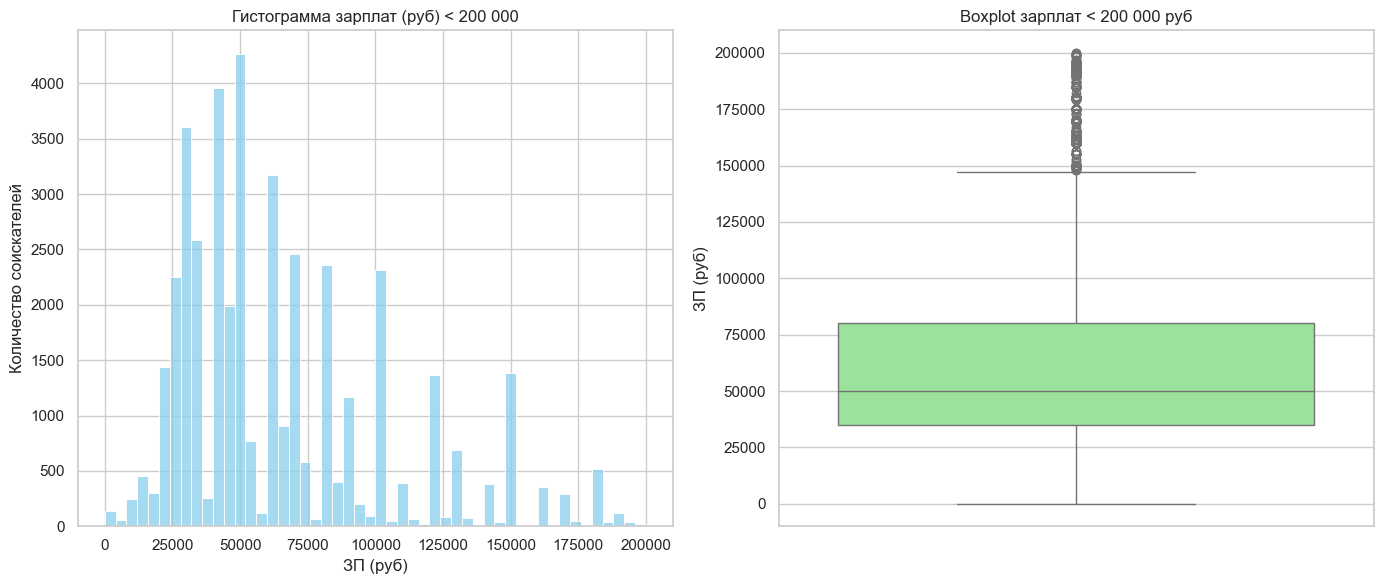

Минимальная зарплата: 1.0
Максимальная зарплата: 24304876.0
Медианная зарплата: 59019.0
Средняя зарплата: 76533.53992967868
Количество соискателей с ЗП > 1 000 000: 5


In [14]:
# ограничим данные, чтобы лучше видеть "обычные" зарплаты (< 200 000)
box_data = hh_df[hh_df['ЗП (руб)'] < 200_000]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Гистограмма
sns.histplot(box_data['ЗП (руб)'], bins=50, kde=False, ax=axes[0], color='skyblue')
axes[0].set_title('Гистограмма зарплат (руб) < 200 000')
axes[0].set_xlabel('ЗП (руб)')
axes[0].set_ylabel('Количество соискателей')

# Коробчатая диаграмма
sns.boxplot(data=box_data, y='ЗП (руб)', ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot зарплат < 200 000 руб')
axes[1].set_ylabel('ЗП (руб)')

plt.tight_layout()
plt.show()

# Дополнительная статистика
print("Минимальная зарплата:", hh_df['ЗП (руб)'].min())
print("Максимальная зарплата:", hh_df['ЗП (руб)'].max())
print("Медианная зарплата:", hh_df['ЗП (руб)'].median())
print("Средняя зарплата:", hh_df['ЗП (руб)'].mean())
print("Количество соискателей с ЗП > 1 000 000:", (hh_df['ЗП (руб)'] > 1_000_000).sum())

**Выводы-**

Предельные значения:

Минимальная зарплата — 1 рубль, считаем что в этом случае зар плата просто не указана 

Максимальная — ~24,3 млн руб. (явные выбросы).

Основной диапазон:

Медианная зарплата — 59 019 руб.,

Средняя — ~76 534 руб. ,  большинство соискателей ориентированы на зарплату 50–80 тыс. руб..

Аномалии - очень высокие значения встречаются редко: всего 5 соискателей просят больше 1 млн руб., что явно выбивается из общей картины.

Вывод - распределение сильно скошено вправо из-за редких гигантских зарплат. Для анализа большинства соискателей стоит ориентироваться на диапазон до 200 тыс. руб., где видно «реальное» распределение

4. В этом шаге я строю диаграмму, которая показывает зависимость медианной зарплаты ("ЗП (руб)") от уровня образования ("Образование"). Для наглядности рассматриваю только данные, где желаемая зарплата меньше 1 млн рублей, чтобы исключить гигантские выбросы.

После визуализации делаю выводы:

определяю, для каких уровней образования медианная зарплата наибольшая и наименьшая;

оцениваю, насколько уровень образования может быть важным признаком при прогнозировании заработной платы.

Медианная зарплата по уровню образования:
среднее: 40000.0 руб.
среднее специальное: 40000.0 руб.
неоконченное высшее: 50000.0 руб.
высшее: 60000.0 руб.


C:\Users\Chuni\AppData\Local\Temp\ipykernel_23316\2708794860.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=median_salary_by_edu.index, y=median_salary_by_edu.values, palette='viridis')


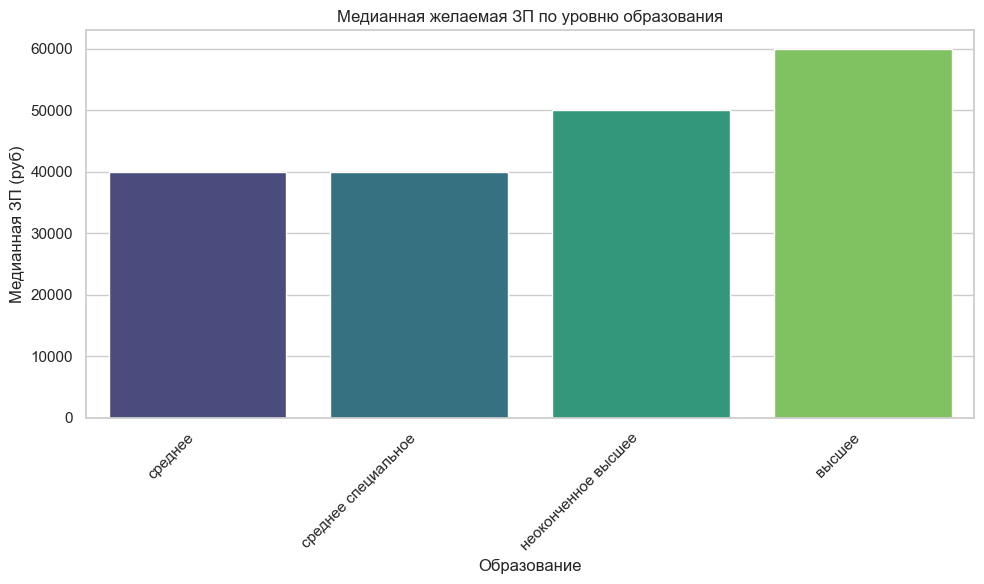

In [15]:
# Фильтруем данные по "обычным" зарплатам (< 1 млн)
edu_data = hh_df[hh_df['ЗП (руб)'] < 1_000_000]

# Группируем по уровню образования и считаем медиану зарплаты
median_salary_by_edu = edu_data.groupby('Образование')['ЗП (руб)'].median().sort_values()

# Печать медианной зарплаты по уровням образования
print("Медианная зарплата по уровню образования:")
for edu, salary in median_salary_by_edu.items():
    print(f"{edu}: {round(salary, 0)} руб.")

# Построение диаграммы
plt.figure(figsize=(10, 6))
sns.barplot(x=median_salary_by_edu.index, y=median_salary_by_edu.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Медианная желаемая ЗП по уровню образования')
plt.ylabel('Медианная ЗП (руб)')
plt.xlabel('Образование')
plt.tight_layout()
plt.show()

**Выводы -** 
Соискатели с высшим образованием имеют наибольшую медианную зарплату — 60 000 руб., что логично 

Те, кто имеет неоконченное высшее образование, ожидают около 50 000 руб. и соискатели со средним и средним специальным образованием имеют наименьшую медианную зарплату — 40 000 руб.

Уровень образования влияет на желаемую зарплату — чем выше образование, тем выше медианная зарплата, этот признак важен при прогнозировании дохода

5. В этом шаге я строю диаграмму, показывающую распределение "ЗП (руб)" в зависимости от признака "Город". Для наглядности рассматриваю только зарплаты меньше 1 млн рублей, чтобы исключить гигантские выбросы.

По диаграмме делаю выводы:

сравниваю медианные значения зарплаты между городами;

оцениваю размах и вариативность зарплат в разных городах;

делаю вывод о том, насколько признак города может быть важным при прогнозировании заработной платы.

C:\Users\Chuni\AppData\Local\Temp\ipykernel_23316\2914807643.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=city_data, x='Город', y='ЗП (руб)', order=ordered_cities, palette='coolwarm')


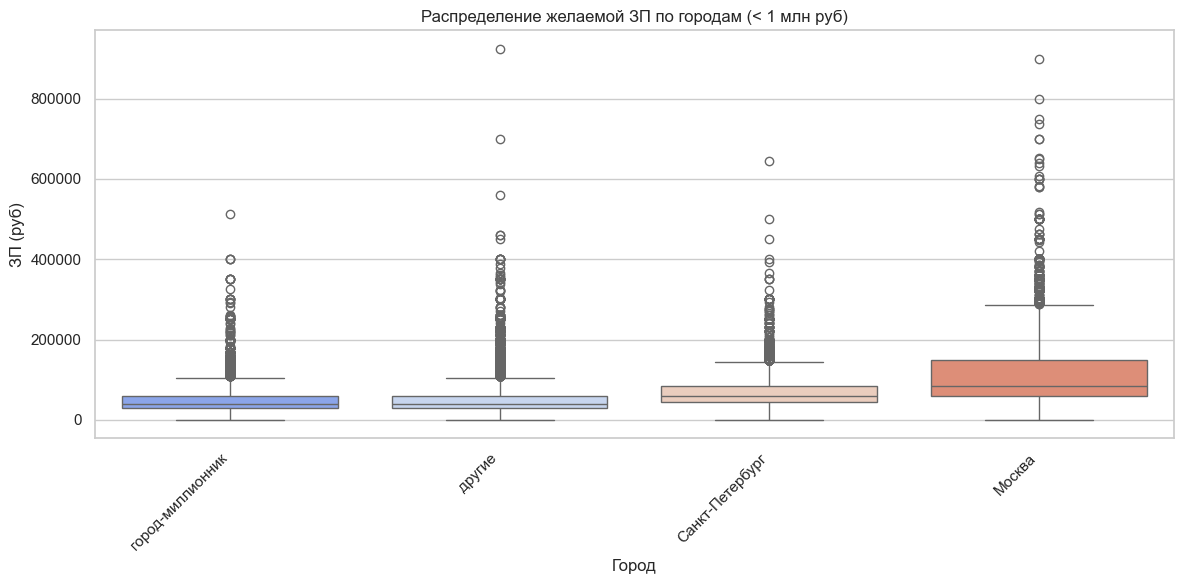

Медианная зарплата по городам:
город-миллионник: 40000.0 руб.
другие: 40000.0 руб.
Санкт-Петербург: 60000.0 руб.
Москва: 85000.0 руб.


In [16]:
# Фильтруем данные по "обычным" зарплатам (< 1 млн)
city_data = hh_df[hh_df['ЗП (руб)'] < 1_000_000]

# Группируем по городам и считаем медиану для сортировки (чтобы график был нагляднее)
median_by_city = city_data.groupby('Город')['ЗП (руб)'].median().sort_values()
ordered_cities = median_by_city.index

# Построение boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=city_data, x='Город', y='ЗП (руб)', order=ordered_cities, palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('Распределение желаемой ЗП по городам (< 1 млн руб)')
plt.ylabel('ЗП (руб)')
plt.xlabel('Город')
plt.tight_layout()
plt.show()

# Вывод медианных зарплат по городам
print("Медианная зарплата по городам:")
for city, salary in median_by_city.items():
    print(f"{city}: {round(salary, 0)} руб.")

**Вывод -**

Москва демонстрирует наибольшую медианную зарплату — 85 000 руб.

Санкт-Петербург — 60 000 руб.

Города-миллионники и другие города имеют одинаковую медианную зарплату — 40 000 руб.

Уровень желаемой зарплаты сильно зависит от города, особенно крупных мегаполисов. Признак города является важным при прогнозировании, так как показывает явное различие между регионами.


6. В этом шаге я строю многоуровневую столбчатую диаграмму, которая показывает зависимость медианной зарплаты ("ЗП (руб)") от признаков "Готовность к переезду" и "Готовность к командировкам".

После построения графика анализирую данные:

сравниваю медианный уровень зарплаты в разных комбинациях готовности к переезду и командировкам;

делаю выводы о том, как эти признаки могут влиять на желаемый уровень заработной платы.

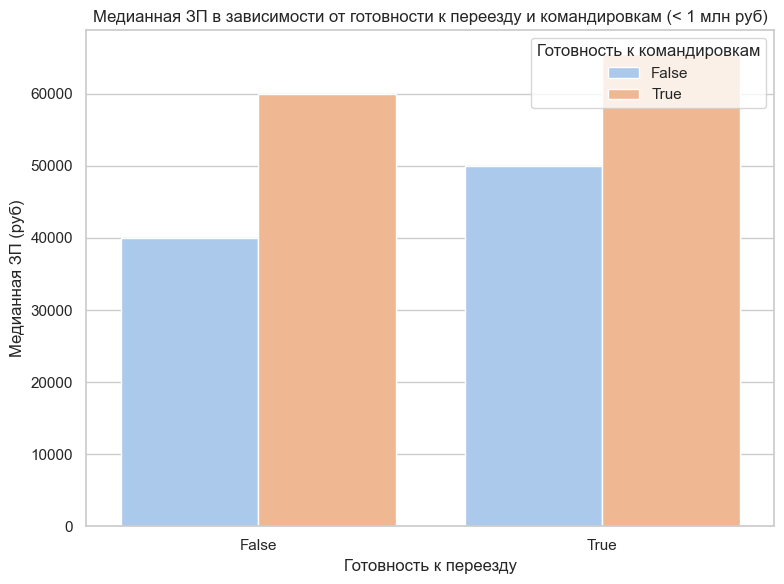

Медианная зарплата по категориям:
   Готовность к переезду  Готовность к командировкам  ЗП (руб)
0                  False                       False   40000.0
1                  False                        True   60000.0
2                   True                       False   50000.0
3                   True                        True   65535.0


In [17]:
# Фильтруем данные по "обычным" зарплатам (< 1 млн)
reloc_data = hh_df[hh_df['ЗП (руб)'] < 1_000_000]

# Группируем и считаем медиану
median_salary = reloc_data.groupby(['Готовность к переезду', 'Готовность к командировкам'])['ЗП (руб)'].median().reset_index()

# Построение многоуровневой столбчатой диаграммы
plt.figure(figsize=(8, 6))
sns.barplot(
    data=median_salary, 
    x='Готовность к переезду', 
    y='ЗП (руб)', 
    hue='Готовность к командировкам', 
    palette='pastel'
)
plt.title('Медианная ЗП в зависимости от готовности к переезду и командировкам (< 1 млн руб)')
plt.ylabel('Медианная ЗП (руб)')
plt.xlabel('Готовность к переезду')
plt.legend(title='Готовность к командировкам')
plt.tight_layout()
plt.show()

# Печать медианных зарплат для анализа
print("Медианная зарплата по категориям:")
print(median_salary)

**Вывод -**

Наименьшая медианная зарплата — 40 000 руб. у соискателей, которые не готовы ни к переезду, ни к командировкам.

Средняя зарплата выше (50 000 руб.), если соискатель готов к переезду, но не к командировкам.

Если готов к командировкам, медианная зарплата увеличивается:

60 000 руб. — не готов к переезду, но готов к командировкам,

65 535 руб. — готов и к переезду, и к командировкам.

Оба признака — готовность к переезду и к командировкам — влияют на желаемую зарплату.

Гибкость соискателя напрямую связана с более высокими ожиданиями по зарплате, поэтому эти признаки важны при прогнозировании

7. В этом шаге я создаю сводную таблицу, которая показывает зависимость медианной зарплаты ("ЗП (руб)") от признаков "Возраст" и "Образование".

На основе этой сводной таблицы строю тепловую карту, чтобы визуально оценить различия внутри групп.

Далее анализирую карту:

сравниваю медианные зарплаты между возрастными группами и уровнями образования;

делаю выводы о том, как сочетание возраста и образования влияет на желаемый уровень заработной платы.

Образование     высшее  неоконченное высшее    среднее  среднее специальное
Возраст                                                                    
14            60000.00                  NaN        NaN                  NaN
15                 NaN                  NaN   10000.00               2000.0
16           122582.49                  NaN        NaN              30000.0
17            90075.50              80000.0   44000.00              25000.0
18            30000.00              25000.0   35000.00              25151.0
19            30000.00              30000.0   45000.00              30000.0
20            30000.00              31000.0   29000.00              30000.0
21            35000.00              35000.0   40000.00              30000.0
22            40000.00              40000.0   40000.00              30000.0
23            45000.00              40000.0   35000.00              35000.0
24            50000.00              40000.0   45000.00              35000.0
25          

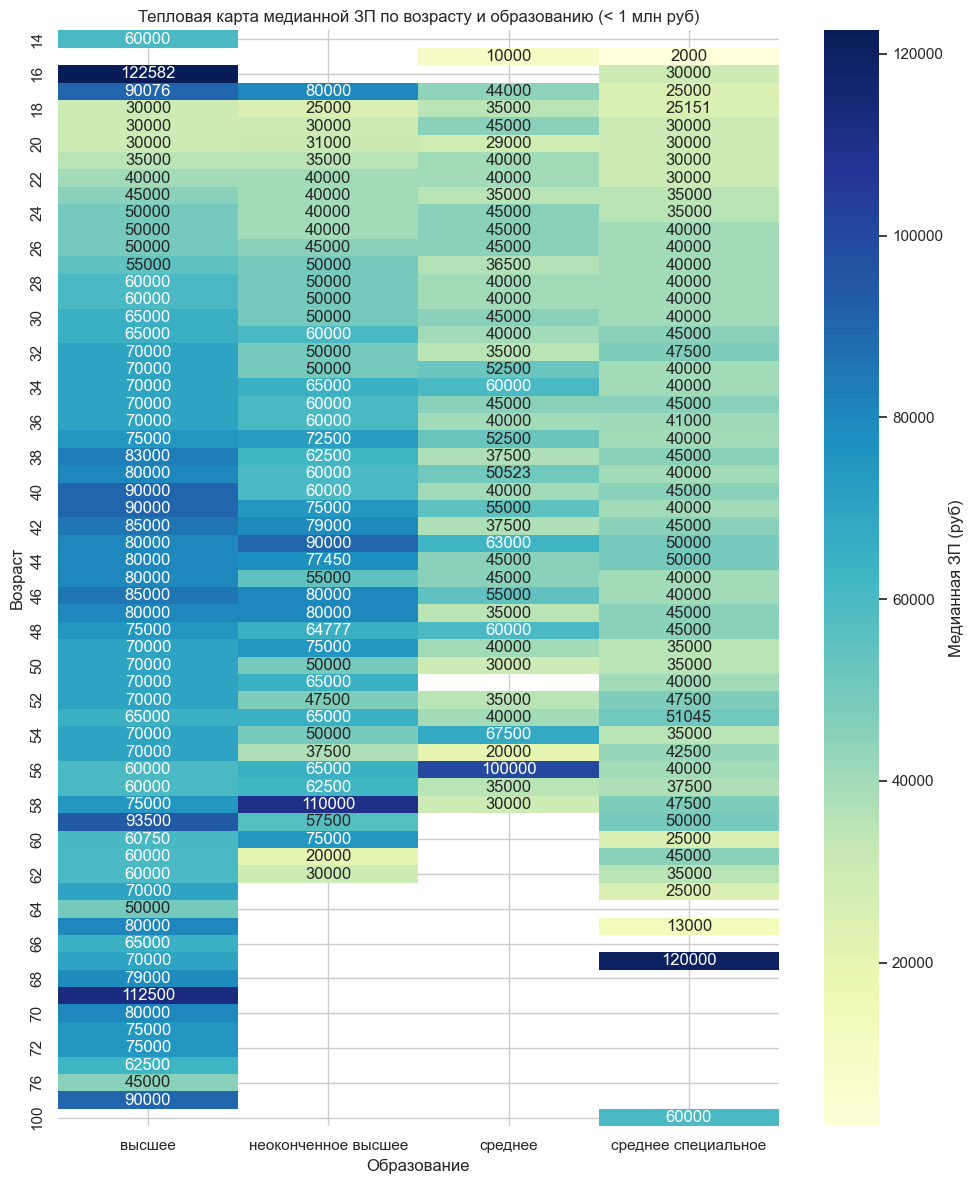

In [18]:
# Ограничиваем данные "обычными" зарплатами (< 1 млн руб)
heat_data = hh_df[hh_df['ЗП (руб)'] < 1_000_000]

# Создаем сводную таблицу
pivot_table = heat_data.pivot_table(
    index='Возраст',
    columns='Образование',
    values='ЗП (руб)',
    aggfunc='median'
)

# Настройки Pandas для отображения всех столбцов и строк
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Вывод сводной таблицы
print(pivot_table)

# Построение тепловой карты
plt.figure(figsize=(10, 12))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".0f", cbar_kws={'label': 'Медианная ЗП (руб)'})
plt.title('Тепловая карта медианной ЗП по возрасту и образованию (< 1 млн руб)')
plt.ylabel('Возраст')
plt.xlabel('Образование')
plt.tight_layout()
plt.show()


Анализ медианных зарплат по возрасту и образованию:

*Влияние образования:*

Соискатели с высшим образованием стабильно демонстрируют наибольшие медианные зарплаты — в среднем 60–90 тыс. руб. в наиболее активном возрасте (25–45 лет).

Неоконченное высшее даёт немного меньше — 40–80 тыс. руб. в среднем, с некоторыми пиками в отдельных возрастных группах (например, 58 лет — 110 тыс.).

Среднее и среднее специальное образование чаще всего ориентируются на 30–50 тыс. руб.

*Влияние возраста:*

До 20 лет зарплаты низкие — логично, мало опыта.

Возраст 25–40 лет — зона наибольших медианных зарплат для всех уровней образования.

После 45 лет зарплаты в большинстве случаев стабилизируются или слегка снижаются, за исключением редких выбросов.

*Выбросы и аномалии:*

Есть отдельные высокие значения (например, 16 лет — 122 тыс., 58 лет — 110 тыс., 67 лет — 120 тыс.), которые явно выбиваются из общей картины.

**Вывод -**

Возраст и образование одновременно влияют на желаемую зарплату.

Максимальная зарплата достигается в молодом и среднем возрасте (25–45 лет) при высшем образовании.

Для прогнозирования эти два признака являются важными факторами, а выбросы следует учитывать отдельно.

8. В этом шаге я строю диаграмму рассеяния, показывающую зависимость опыта работы ("Опыт работы (месяц)") от возраста ("Возраст"). Для наглядности перевожу опыт работы из месяцев в годы, чтобы оба признака были в одном масштабе.

На графике также добавляю прямую, проходящую через точки (0, 0) и (100, 100). Эта линия показывает теоретический максимум: опыт работы не может превышать возраст.

Точки, расположенные на линии или выше неё, считаются аномальными — это случаи, когда опыт работы больше или равен возрасту соискателя.

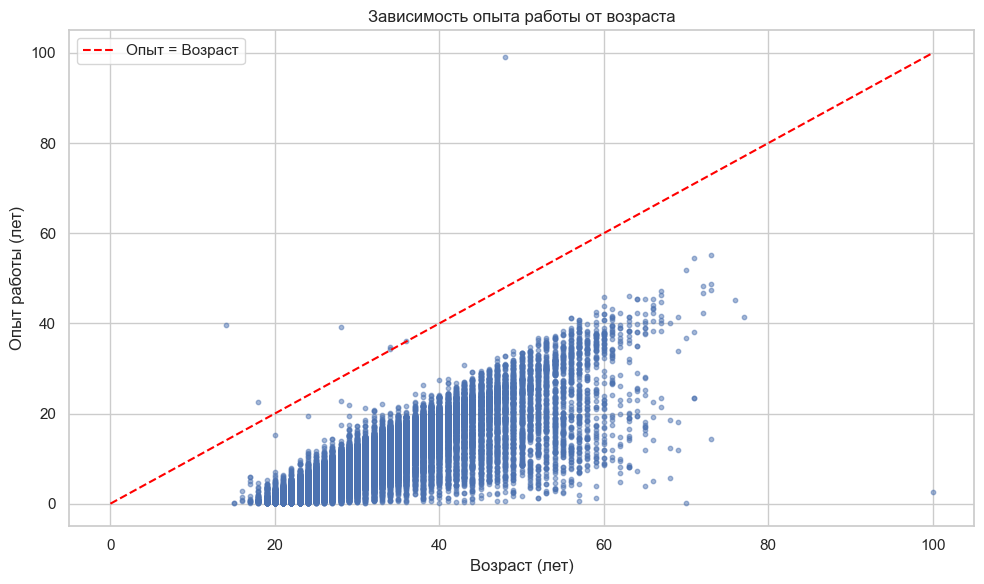

Количество аномалий (Опыт >= Возраст): 7
Примеры аномальных записей:
       Возраст  Опыт работы (год)
4535        18          22.583333
19351       28          39.166667
19872       34          34.666667
26477       34          34.250000
29098       14          39.750000
40015       48          99.000000
43451       36          36.166667


In [19]:
# Создаем копию данных и переводим опыт работы в годы
scatter_data = hh_df.copy()
scatter_data = scatter_data[scatter_data['Опыт работы (месяц)'].notna()]  # исключаем NaN
scatter_data['Опыт работы (год)'] = scatter_data['Опыт работы (месяц)'] / 12

# Построение диаграммы рассеяния
plt.figure(figsize=(10, 6))
plt.scatter(scatter_data['Возраст'], scatter_data['Опыт работы (год)'], alpha=0.5, s=10)
plt.xlabel('Возраст (лет)')
plt.ylabel('Опыт работы (лет)')
plt.title('Зависимость опыта работы от возраста')

# Добавление прямой y = x
x = range(0, 101)
plt.plot(x, x, color='red', linestyle='--', label='Опыт = Возраст')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Определение аномалий (Опыт >= Возраст)
anomalies = scatter_data[scatter_data['Опыт работы (год)'] >= scatter_data['Возраст']]
print(f"Количество аномалий (Опыт >= Возраст): {len(anomalies)}")
print("Примеры аномальных записей:")
print(anomalies[['Возраст', 'Опыт работы (год)']].head(10))

Анализ зависимости опыта работы от возраста

Всего 7 аномалий, где опыт работы ≥ возраст — данные явно ошибочные (например, 14 лет с 39 годами опыта).

В остальных случаях опыт растет с возрастом, как ожидается.

**Вывод -**

Большинство данных корректны, но редкие выбросы могут искажать анализ или модели.

Аномалии стоит удалить или исправить перед дальнейшей обработкой

9. В этом блоке я анализирую зависимость зарплаты ("ЗП (руб)") от пола ("Пол") с учётом города проживания.

Сначала строю четыре коробчатые диаграммы для категорий городов:

"Москва" "Санкт-Петербург" "город-миллионник" "другие"

На каждой диаграмме отображается распределение зарплат для мужчин и женщин, с ограничением по оси Y до 200.000 рублей для наглядности.

Затем строю общую диаграмму для всей выборки, чтобы сравнить зависимость зарплаты от пола без учёта города.

Анализируя графики, можно визуально оценить различия медианной зарплаты и вариативности в разных городах и между полами.

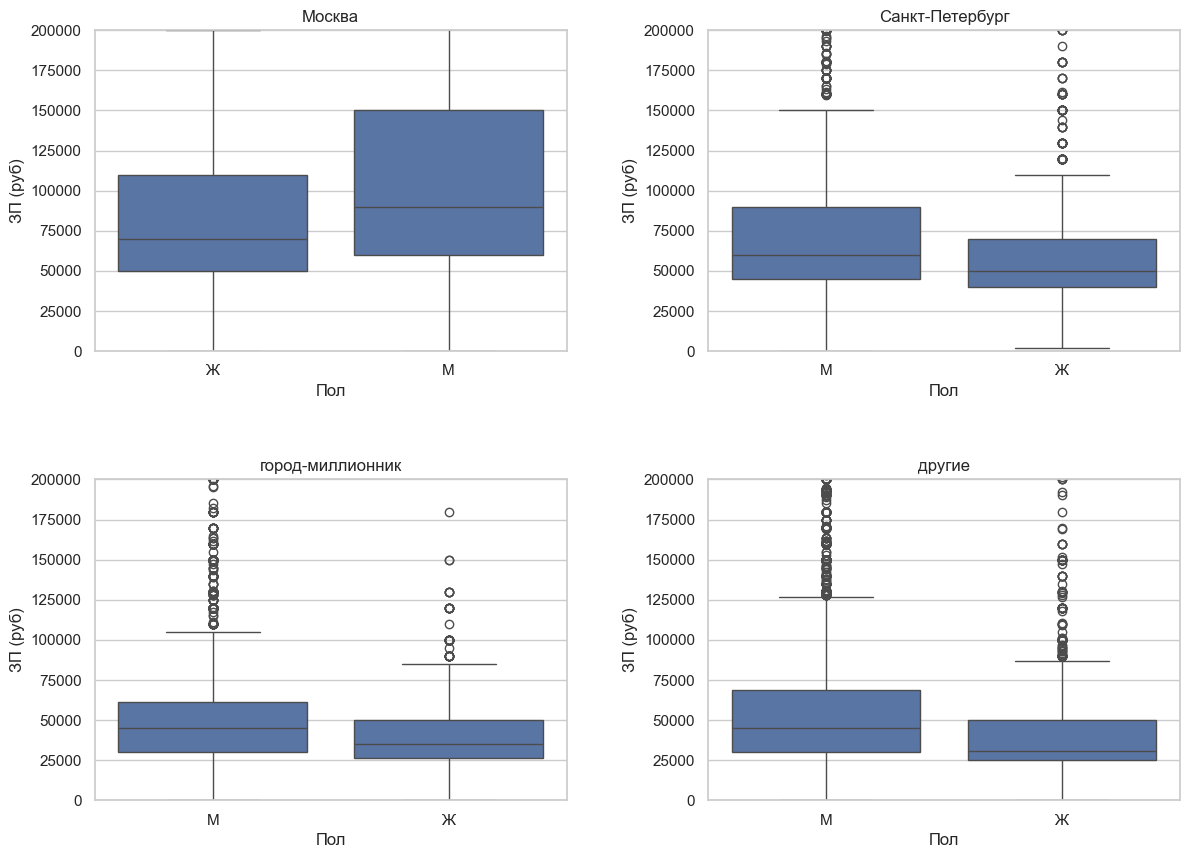

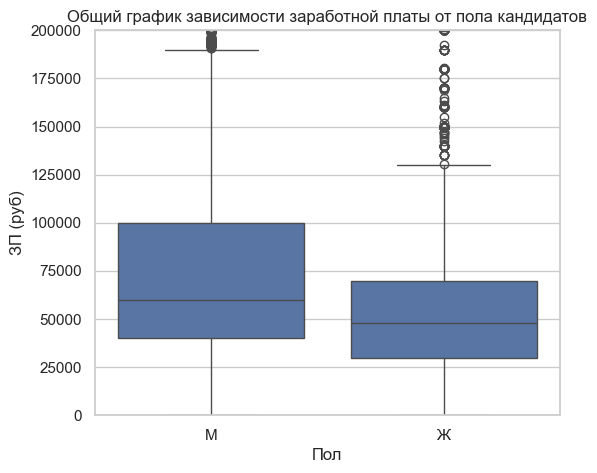

In [20]:
# 4 графика по анализу зависимости Зар.плата/Пол по "городам" 
fig, axes = plt.subplots(2, 2, figsize=(14,10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

categories = ['Москва', 'Санкт-Петербург', 'город-миллионник', 'другие']

for ax, cat in zip(axes.flatten(), categories):
    sns.boxplot(x='Пол', y='ЗП (руб)', data=hh_df[hh_df['Город']==cat], ax=ax)
    ax.set_title(f'{cat}')
    ax.set_ylim(0, 200000)
    ax.set_ylabel('ЗП (руб)')
    ax.set_xlabel('Пол')

# Общий график для всей выборки
plt.figure(figsize=(6,5))
sns.boxplot(x='Пол', y='ЗП (руб)', data=hh_df)
plt.title('Общий график зависимости заработной платы от пола кандидатов')
plt.ylim(0, 200000)
plt.ylabel('ЗП (руб)')
plt.xlabel('Пол')
plt.show()

**Вывод -**  в среднем желаемая зарплата мужчин выше, чем у женщин, что видно по распределению на графиках в не зависимости от признака "город", пол весомый признак влияющий на зар плату 

10. В этом блоке я анализирую запрашиваемые (желанные) типы занятости соискателей по городам.

Сначала преобразую таблицу в длинный формат, чтобы каждая строка соответствовала конкретному типу занятости и городу. Оставляю только выбранные типы (значение True). Названия типов занятости перевожу на русский для удобства визуализации.

Далее строю несколько графиков:

Countplot — показывает количество соискателей каждого типа занятости по городам.

Heatmap — визуализирует сводную таблицу с количеством соискателей по каждому типу занятости в каждом городе.

После этого создаю строку с итоговым количеством по каждому типу занятости и объединяю её с таблицей, чтобы видеть общее количество кандидатов.

В завершение строю круговую диаграмму, показывающую долю каждого типа занятости среди всех соискателей.

Анализируя графики и таблицы, можно понять, какие типы занятости наиболее востребованы в разных городах и в целом.

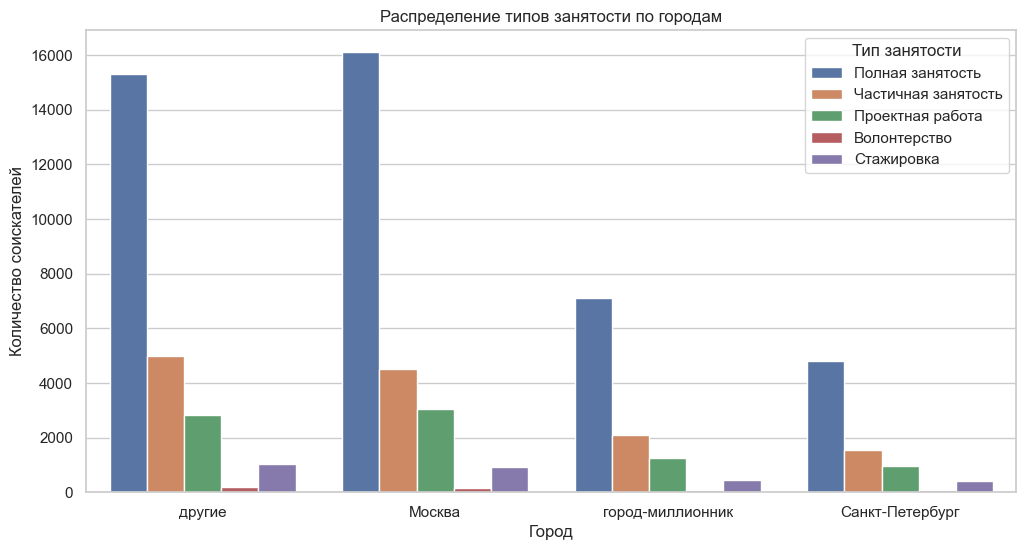

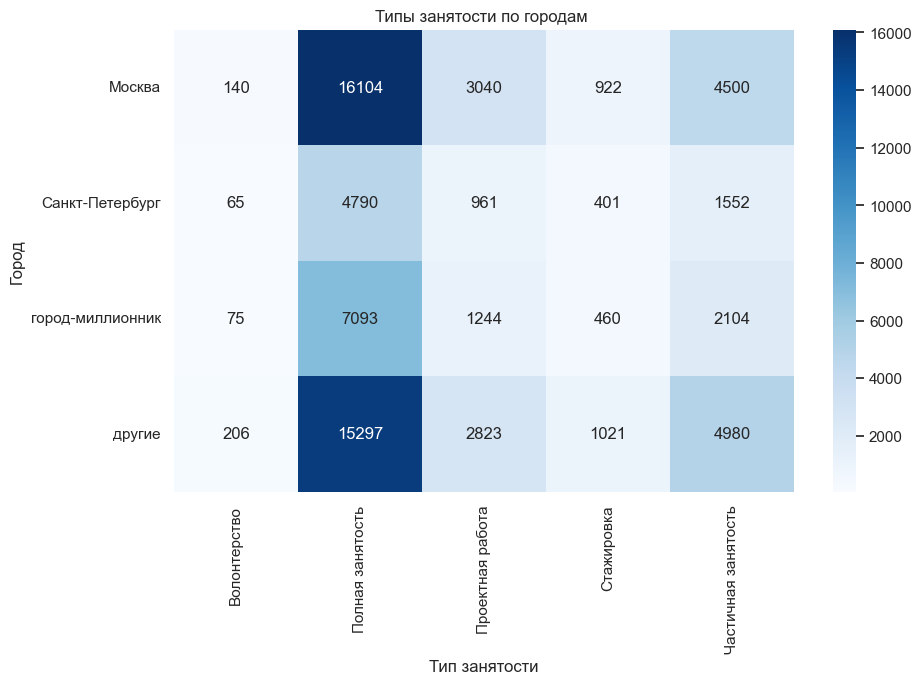

Количество кандидатов по типу занятости и городу с суммой по всем городам:


Тип_занятости,Волонтерство,Полная занятость,Проектная работа,Стажировка,Частичная занятость
Москва,140,16104,3040,922,4500
Санкт-Петербург,65,4790,961,401,1552
город-миллионник,75,7093,1244,460,2104
другие,206,15297,2823,1021,4980
Итого,486,43284,8068,2804,13136


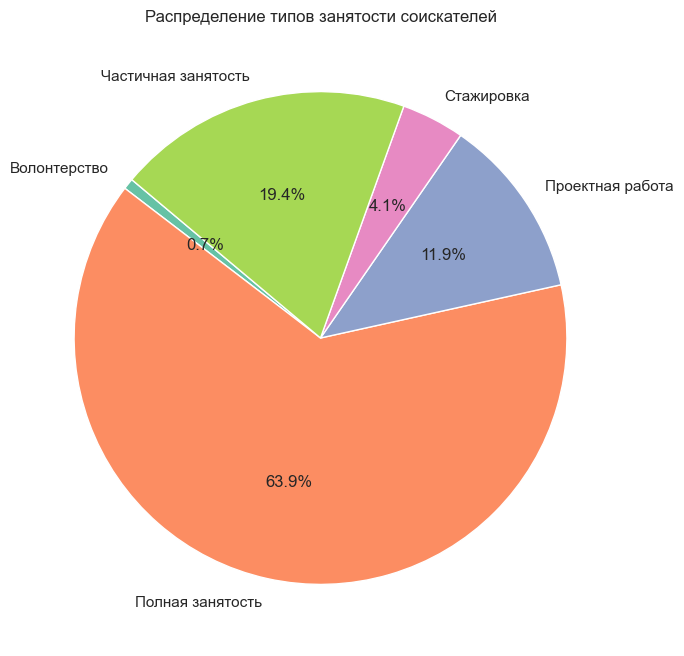

In [21]:
# Анализ желаемых типов занятости соискателей по городам 

# Список колонок с типами занятости
employment_types = ['полная занятость', 'частичная занятость', 'проектная работа', 'волонтерство', 'стажировка']

# Преобразуем датафрейм в длинный формат
hh_long = hh_df.melt(
    id_vars=['Город'], 
    value_vars=employment_types, 
    var_name='Тип_занятости', 
    value_name='Выбран'
)

# Оставляем только выбранные типы (True)
hh_long = hh_long[hh_long['Выбран']]

# Поменяем названия типов занятости на русский для графика 
hh_long['Тип_занятости'] = hh_long['Тип_занятости'].replace({
    'полная занятость': 'Полная занятость',
    'частичная занятость': 'Частичная занятость',
    'проектная работа': 'Проектная работа',
    'волонтерство': 'Волонтерство',
    'стажировка': 'Стажировка'
})

# Вариант 1 Countplot 
plt.figure(figsize=(12,6))
sns.countplot(x='Город', hue='Тип_занятости', data=hh_long)
plt.title('Распределение типов занятости по городам')
plt.xlabel('Город')
plt.ylabel('Количество соискателей')
plt.legend(title='Тип занятости')
plt.show()

# Вариант 2 Heatmap 
# Создаем сводную таблицу: города x типы занятости
pivot = hh_long.pivot_table(index='Город', columns='Тип_занятости', aggfunc='size', fill_value=0)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues')
plt.title('Типы занятости по городам ')
plt.xlabel('Тип занятости')
plt.ylabel('Город')
plt.show()

# Создаем строку с суммой по каждому типу занятости
totals = pivot.sum().to_frame().T  # превращаем Series в DataFrame
totals.index = ['Итого']  # задаем имя строки

# Объединяем с исходной таблицей
pivot_with_total = pd.concat([pivot, totals])

# Выводим таблицу по соискателям (тип занятости + город) с суммой 
print("Количество кандидатов по типу занятости и городу с суммой по всем городам:")
display(pivot_with_total)

# Построение круговой диаграммы
total_row = pivot_with_total.loc['Итого']

plt.figure(figsize=(8,8))
plt.pie(
    total_row.values, 
    labels=total_row.index, 
    autopct='%1.1f%%', 
    startangle=140,
    colors=['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854']
)
plt.title('Распределение типов занятости соискателей')
plt.show()

**Вывод -** Большинство соискателей ищут полную занятость почти 64%, на втором месте по популярности — частичная занятость 19%. Эта тенденция примерно одинаково наблюдается во всех категориях городов

# Очистка данных

1. В этом блоке я работаю с дубликатами дата фрейме с резюме. Сначала ищу полные дубликаты — строки, которые полностью повторяются. После проверки удаляю их, чтобы в данных остались только уникальные записи.

In [22]:
# Посчитаем количество полных дубликатов
num_duplicates = hh_df.duplicated().sum()
print("Количество полных дубликатов:", num_duplicates)

# Удалим дубликаты
hh_df = hh_df.drop_duplicates()


Количество полных дубликатов: 161


2. В этом блоке я анализирую пропуски в данных. Вывожу количество пропусков в каждом столбце, чтобы понять, где отсутствуют значения и насколько это может повлиять на дальнейшую обработку

In [23]:
# Посмотрим количество пропусков по всем колонкам
missing_counts = hh_df.isna().sum()
print(missing_counts)

# Пропуски конкретно в столбце "Опыт работы (месяц)"
missing_experience = hh_df['Опыт работы (месяц)'].isna().sum()
print("Пропусков в 'Опыт работы (месяц)':", missing_experience)

Ищет работу на должность:            0
Последнее/нынешнее место работы      1
Последняя/нынешняя должность         2
Обновление резюме                    0
Авто                                 0
Образование                          0
Пол                                  0
Возраст                              0
Опыт работы (месяц)                168
Город                                0
Готовность к переезду                0
Готовность к командировкам           0
полная занятость                     0
частичная занятость                  0
проектная работа                     0
волонтерство                         0
стажировка                           0
полный день                          0
сменный график                       0
гибкий график                        0
удаленная работа                     0
вахтовый метод                       0
ЗП (руб)                             0
dtype: int64
Пропусков в 'Опыт работы (месяц)': 168


3. В этом блоке я обрабатываю пропуски в трёх столбцах: "Опыт работы (месяц)", "Последнее/нынешнее место работы" и "Последняя/нынешняя должность".

Строки, где отсутствуют данные о месте работы или должности, удаляю, так как эта информация критична.

Пропуски в столбце "Опыт работы (месяц)" заполняю медианным значением, чтобы сохранить распределение признака и минимизировать влияние на анализ.

In [24]:
# Удаляем строки с пропусками в столбцах о месте работы и должности
hh_df = hh_df.dropna(subset=['Последнее/нынешнее место работы', 'Последняя/нынешняя должность'])

# Заполняем пропуски в столбце "Опыт работы (месяц)" медианой
median_experience = hh_df['Опыт работы (месяц)'].median()
hh_df['Опыт работы (месяц)'] = hh_df['Опыт работы (месяц)'].fillna(median_experience)

# Проверим, что пропусков больше нет
missing_counts_after = hh_df.isna().sum()
print(missing_counts_after)


# Среднее значение опыта работы после заполнения пропусков
mean_experience = hh_df['Опыт работы (месяц)'].mean()
print("Средний опыт работы (месяц), округлённый до целого:", round(mean_experience))

Ищет работу на должность:          0
Последнее/нынешнее место работы    0
Последняя/нынешняя должность       0
Обновление резюме                  0
Авто                               0
Образование                        0
Пол                                0
Возраст                            0
Опыт работы (месяц)                0
Город                              0
Готовность к переезду              0
Готовность к командировкам         0
полная занятость                   0
частичная занятость                0
проектная работа                   0
волонтерство                       0
стажировка                         0
полный день                        0
сменный график                     0
гибкий график                      0
удаленная работа                   0
вахтовый метод                     0
ЗП (руб)                           0
dtype: int64
Средний опыт работы (месяц), округлённый до целого: 114


4. В этом блоке я начинаю обработку выбросов в данных. Сначала выполняю ручную очистку:

удаляю резюме, где желаемая зарплата указана выше 1 млн рублей или ниже 1 тыс. рублей, так как эти значения крайне маловероятны и сильно искажают анализ.

In [25]:
# Сохраняем форму датафрейма до фильтрации, для подсвета удалённых строк
rows_before = hh_df.shape[0]

# Удаляем резюме с ЗП < 1000 или > 1_000_000 рублей
hh_df = hh_df[(hh_df['ЗП (руб)'] >= 1000) & (hh_df['ЗП (руб)'] <= 1_000_000)]

# Считаем, сколько строк удалилось
rows_after = hh_df.shape[0]
deleted_rows = rows_before - rows_after

print("Количество удалённых резюме:", deleted_rows)
print("Форма датафрейма после фильтрации по ЗП:", hh_df.shape)


Количество удалённых резюме: 89
Форма датафрейма после фильтрации по ЗП: (44492, 23)


5. В этом блоке я выявляю аномалии в опыте работы.

Ищу резюме, где опыт работы (в годах) превышает возраст соискателя, что невозможно в реальности.

После проверки удаляю эти записи, чтобы очистить данные и сделать анализ корректным.


In [26]:
# Переводим опыт работы из месяцев в годы
hh_df['Опыт работы (год)'] = hh_df['Опыт работы (месяц)'] / 12

# Находим резюме, где опыт больше возраста
invalid_experience = hh_df[hh_df['Опыт работы (год)'] > hh_df['Возраст']]
print("Количество резюме с опытом больше возраста:", invalid_experience.shape[0])

# Удаляем эти резюме
hh_df = hh_df[hh_df['Опыт работы (год)'] <= hh_df['Возраст']]

# Проверка
print("Форма датафрейма после удаления некорректного опыта:", hh_df.shape)

Количество резюме с опытом больше возраста: 7
Форма датафрейма после удаления некорректного опыта: (44485, 24)


6. В этом блоке я анализирую выбросы в признаке "Возраст":

Строю распределение возраста в логарифмическом масштабе для наглядности.

Добавляю линии, показывающие среднее и границы интервала по методу трёх сигм (с небольшой корректировкой: для правой границы использую 4 сигмы).

По графику оцениваю асимметрию распределения.

С помощью z-отклонений нахожу и удаляю выбросы из данных.

Вывожу таблицу с удалёнными резюме, чтобы увидеть, с каким возрастом соискатели попадают в категорию выбросов.

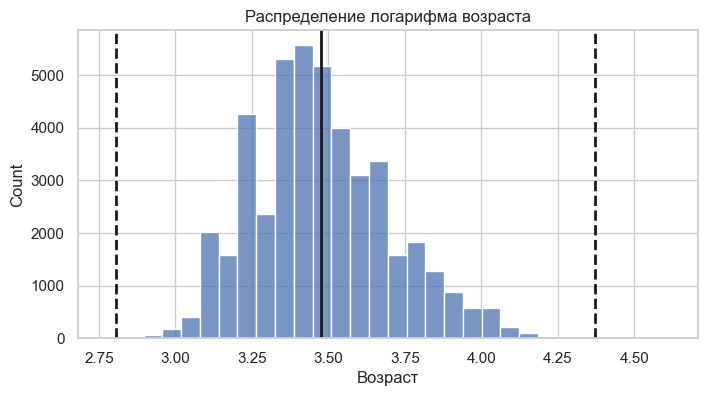

Количество выбросов по возрасту: 3
Возраст соискателей, попавших в выбросы:
        Возраст
31137       15
32950       15
33654      100
Форма датафрейма после удаления выбросов по возрасту: (44482, 24)


In [27]:
# строим распределение логарифма возраста
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_age = np.log(hh_df['Возраст'] + 1)
histplot = sns.histplot(log_age, bins=30, ax=ax)
histplot.axvline(log_age.mean(), color='k', lw=2)
histplot.axvline(log_age.mean() + 4*log_age.std(), color='k', ls='--', lw=2)
histplot.axvline(log_age.mean() - 3*log_age.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение логарифма возраста')
# распределение логарифма возраста имеет правостороннюю асимметрию с длинным правым хвостом
plt.show()

# функция для поиска выбросов методом z отклонений
def outliers_z_score_mod(data, feature, left=3, right=3, log_scale=False):
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

# находим выбросы по возрасту и очищаем данные
outliers, hh_df = outliers_z_score_mod(hh_df, 'Возраст', left=3, right=4, log_scale=True)

# вывод информации о выбросах
print("Количество выбросов по возрасту:", outliers.shape[0])
print("Возраст соискателей, попавших в выбросы:\n", outliers[['Возраст']])


# удаляем резюме с возрастом меньше 16 или больше 99 лет
hh_df = hh_df[(hh_df['Возраст'] > 15) & (hh_df['Возраст'] < 100)]

# проверяем результат
print("Форма датафрейма после удаления выбросов по возрасту:", hh_df.shape)

**Вывод -**  данные содержат ошибки или аномалии, которые могут исказить анализ. Эти резюме были удалены , чтобы расчёты по возрасту были корректными 
